In [98]:
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy.stats import nbinom,poisson,norm
from scipy.special import binom
from scipy.special import factorial
#import seaborn as sns
#%config InlineBackend.figure_format = 'retina'
from scipy.interpolate import interp1d,pchip
from scipy.integrate import odeint, solve_ivp, solve_bvp
from scipy.optimize import differential_evolution
import warnings
warnings.filterwarnings("ignore")
import emcee
import corner
from multiprocessing import Pool

In [2]:
owid='https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv'
owid='https://covid.ourworldindata.org/data/owid-covid-data.csv'

df = pd.read_csv(owid,parse_dates=['date'])

dfG=df[df['iso_code']=='GRC']

In [ ]:
dfG.tail()[['date','new_cases','new_deaths','new_tests']]

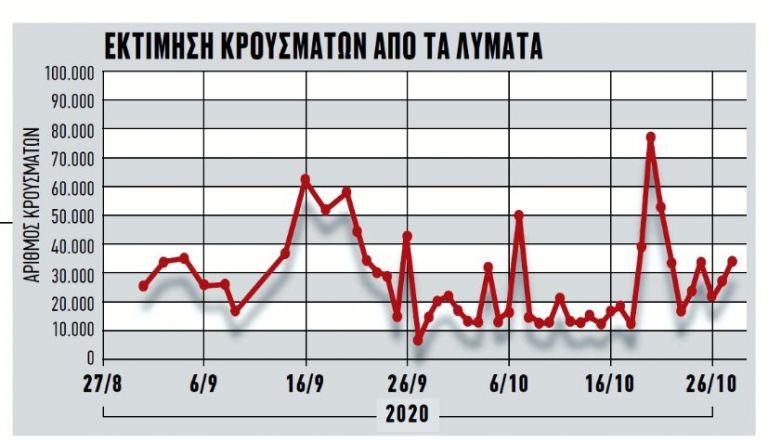

In [ ]:
sewer_data_t=['2020-09-06','2020-09-16','2020-09-26','2020-10-06','2020-10-16','2020-10-26','2020-11-07']
sewer_data_C_athens=np.array([25000,60000,30000,17000,15000,25000,70000])
sewer_data_C_athens_error=np.array([5000,10000,10000,5000,10000,10000,10000])

sewer_data_t=['2020-10-06','2020-10-16','2020-10-26','2020-11-07']
sewer_data_C_athens=np.array([17000,15000,25000,70000])
sewer_data_C_athens_error=np.array([5000,10000,10000,10000])

In [108]:
date0=dfG.iloc[0]['date']
N=1e7
dfG['d']=dfG['date']-date0
t=np.array(dfG['d']/ np.timedelta64(1, 'D'))
C=np.array(dfG['total_cases'])
Cd=np.array(dfG['new_cases'])
D=np.array(dfG['total_deaths'])
Dd=np.array(dfG['new_deaths'])
tst=np.array(dfG['new_tests_smoothed'])
#tst=np.array(dfG['total_tests'])

sewer_data_tt=[(np.datetime64(ti)-date0)/ np.timedelta64(1, 'D') for ti in sewer_data_t]
dfG['sewers']=np.nan
dfG['sewers_error']=np.nan
for ti,ci,dci in zip(sewer_data_t,sewer_data_C_athens,sewer_data_C_athens_error):
    dfG.at[dfG['date']==np.datetime64(ti),'sewers']=ci
    dfG.at[dfG['date']==np.datetime64(ti),'sewers_error']=dci

# Sewer data calculation
# sewer data are for athens and only for active cases
# we make an estimation of official/real cases 
# assuming athens/greece ~0.25 +/- 0.1 of the cases
# and active time for sewer detection ~ 10+/-6 days
athens_ratio=0.25; dathens_ratio=0.1
sewer_days=10; dsewer_days=6
sewer_data_C=np.array(dfG['sewers'])
sewer_data_C_error=np.array(dfG['sewers_error'])

crit_cases=0 # start counting days from day with more thn crit cases
tt=t[C>crit_cases]-t[C>crit_cases][0]

# special events to plot on R(t) figure
events={'schools closed':(np.datetime64('2020-03-10')-date0)/ np.timedelta64(1, 'D')-t[C>crit_cases][0],
        "quarantine":(np.datetime64('2020-03-20')-date0)/ np.timedelta64(1, 'D')-t[C>crit_cases][0],
        "quarantine finished":(np.datetime64('2020-04-27')-date0)/ np.timedelta64(1, 'D')-t[C>crit_cases][0],
       "quarantine2":(np.datetime64('2020-11-07')-date0)/ np.timedelta64(1, 'D')-t[C>crit_cases][0]}

extrapolate_days = 40 #prdeict the future

tt_extrapolate=np.arange(tt[0],tt[-1]+extrapolate_days)
cc = C[C>crit_cases]
ccd = Cd[C>crit_cases]
dd= D[C>crit_cases]
ddd= Dd[C>crit_cases]
ttst= tst[C>crit_cases]
ttst[:10]=150 #tests per day before the official test reports
test_pop=ttst/N
d1int=interp1d(tt[~np.isnan(test_pop)],test_pop[~np.isnan(test_pop)],fill_value='extrapolate')
interpolated=d1int(tt_extrapolate)

# test_pop_polfit=np.poly1d(np.polyfit(tt[~np.isnan(test_pop)],test_pop[~np.isnan(test_pop)],5))
test_pop_polfit=np.poly1d(np.polyfit(tt_extrapolate,interpolated,8))
test_pop_polfit=interp1d(tt[~np.isnan(test_pop)],test_pop[~np.isnan(test_pop)],fill_value='extrapolate')

sewer_data_C=sewer_data_C[C>crit_cases]
dsewer_data_C=sewer_data_C_error[C>crit_cases]#0.1*sewer_data_C
sewer_data_C_day=sewer_data_C/athens_ratio/sewer_days
a_test=ccd/(sewer_data_C/athens_ratio/sewer_days)
a_test_error=ccd*np.sqrt( (athens_ratio*dsewer_days/sewer_data_C)**2 + (dathens_ratio*sewer_days/sewer_data_C)**2 +(athens_ratio*sewer_days*dsewer_data_C/sewer_data_C**2)**2)

In [110]:
#SEIRD model parameters
# 1. R0(t) = b(t0)/T_recover, b(t)= spread rate
# 2. T_recover =recovery time
# 3. T_l = non infectious time
# 4. T_d = infectious to death time
# 5. m(t) =  mortality rate
# N= Total Population

def SEIRD(t,Y,R0,m,Tl,Tr,Td,N): 
    S,E,I,R,D=Y
    dS=-R0(t)/Tr*S*I/N
    dE=R0(t)/Tr*S*I/N-E/Tl
    dI=E/Tl-(1-m(t))*I/Tr-m(t)*I/Td
    dR=(1-m(t))*I/Tr
    dD=m(t)*I/Td
    return [dS,dE,dI,dR,dD]

def prepare_params(dicparams):
    p0=[]
    dp=[]
    bounds=[]
    n=0
    for p in dicparams:
        for i in dicparams[p]:
            #print(dicparams[p][i])
            if dicparams[p][i][3]:
                n+=1
                bounds.append(dicparams[p][i][1])
                p0.append(dicparams[p][i][2][0])
                dp.append(dicparams[p][i][2][1])
    print(f'Parameters we are going to fit {n}')
    return np.array(bounds),np.array(p0),np.array(dp)

sewer_weight=0.002 #because the sewer data are very small but also very valuable we add more weight to them for the fitting

def posterior(params,bounds,p0,dp,dicparams,maxt,usefit=False,plot=None):
    """
    posterior function for the model: implements the model along with priors and calculates the posterior logprobabillity
    params: array of fitted parameters that is used if usefit == True else we use only the vars from dicparams
    bounds: boundaries of the FITTED parameters
    priors,dp: Array of mean and array of sigma values for gaussian distributed priors for the FITTED parameters
    dicparams: all the information for the parameters see example
    plot: dictionary where we give plotting options for the results. 
    in order to use it add the name of the plot ('daily_log','cummulative_log','deaths_daily','cases_daily','R0','official/real','mortality','test_bias') and the options which are used in the set function
    """
    outofrange=0
    for i in range(len(params)):
        outofrange+=1-(bounds[i,0] <= params[i] <= bounds[i,1])
    if outofrange:
        return -np.inf
    if usefit:
        n=0
        for p in dicparams:
            for i in dicparams[p]:
                #print(dicparams[p][i])
                if dicparams[p][i][3]:
                    dicparams[p][i][0]=params[n]
                    n+=1
        #print(dicparams)            
    tAt=np.array(list(dicparams['A'].keys()))
    Ats=np.array(list(dicparams['A'].values()))[:,0].astype(float)
    _At=pchip(tAt,Ats)
    
    tmt=np.array(list(dicparams['m'].keys()))
    mts=np.array(list(dicparams['m'].values()))[:,0].astype(float)
    _mt=pchip(tmt,10**mts)
    
    tRt=np.array(list(dicparams['R'].keys()))
    Rts=np.array(list(dicparams['R'].values()))[:,0].astype(float)
    _Rt=pchip(tRt,Rts)
    
    Tl=list(dicparams['Tl'].values())[0][0]
    Tr=list(dicparams['Tr'].values())[0][0]
    Td=list(dicparams['Td'].values())[0][0]
    Tof=list(dicparams['Tof'].values())[0][0]
    E0=list(dicparams['E0'].values())[0][0]
    I0=list(dicparams['I0'].values())[0][0]
    
    Y0=[N,E0,I0,0,0]
    #print(N,E0,I0,Tl,Tr,Td,Tof)
    #print(tAt,Ats)
    sols=solve_ivp(SEIRD,(tt_extrapolate[0],tt_extrapolate[-1]),Y0,t_eval=tt_extrapolate,args=(_Rt,_mt,Tl,Tr,Td,N))
    #print(sols)
    model_cases_new=np.roll(sols['y'][2],int(Tof))
    model_cases_new[:int(Tof)]=0
    model_cases_new=_At(tt_extrapolate)*test_pop_polfit(tt_extrapolate)*model_cases_new
    model_cases=np.cumsum(model_cases_new)
    
    #print(_mt(100),Td,np.diff(sols['y'][4]))
    model_deaths=sols['y'][4]
    
    
    #model_deaths=_mt(tt)*model_deaths
    tlim=len(tt)#min(len(tt),maxt)
    
    cases_like=np.nansum((model_cases[:tlim]-cc[:tlim])**2/cc[:tlim])
    death_like=np.nansum((model_deaths[:tlim]-dd[:tlim])**2/dd[:tlim])
    
    sewer_model=model_cases_new[:tlim][~np.isnan(a_test)]/sols['y'][2][:tlim][~np.isnan(a_test)]
    sewer_error=2*a_test_error[~np.isnan(a_test)]**2*sewer_weight
    sewer_like=np.nansum((sewer_model-a_test[~np.isnan(a_test)])**2/sewer_error)
    
    priors=np.sum((p0-np.array(params))**2/(2*dp**2))
    #print(sewer_model)
    #print(a_test[~np.isnan(a_test)])
    #print(sewer_error)
    #print(cases_like,death_like,sewer_like,(sewer_model-a_test[~np.isnan(a_test)])**2/sewer_error,priors)
    post=cases_like+death_like+sewer_like+priors
    
    if plot is None:
        return post
    else:
        xlim = plot['xlim'] if 'xlim' in plot.keys() else None
        print(post)
        print(f'tommorow cases/deaths: {model_cases_new[int(tt[-1])+1]:.0f}/{model_deaths[int(tt[-1])+1]-model_deaths[int(tt[-1])]:.0f}')
        figsize=(28,14) #figure size
        mosaic= [['daily_log','cummulative_log','deaths_daily','cases_daily'],['R0','official/real','mortality','test_bias']]
        gridspec_kw={'width_ratios': [1,1,1,1],'height_ratios': [1,1]}
        fig = plt.figure(constrained_layout=False,figsize=figsize)
        ax = fig.subplot_mosaic(mosaic,gridspec_kw=gridspec_kw)

        ax['daily_log'].plot(tt_extrapolate,sols['y'][1],label='E ')
        ax['daily_log'].plot(tt_extrapolate,sols['y'][2],linewidth=4,label='I (Infected)')
        ax['daily_log'].plot(tt_extrapolate,model_cases_new,linewidth=4,label='I*=I*tests/N*A(t)')
        ax['daily_log'].plot(tt_extrapolate[:len(tt)],ttst,label='tests')
        ax['daily_log'].bar(tt,ccd,label='official cases',alpha=0.3)
        ax['daily_log'].bar(tt,ddd,label='official deaths',alpha=0.3)
        ax['daily_log'].set(yscale='log',ylabel='Daily Number',xlabel='',ylim=[None,3e5])
        

        ax['cummulative_log'].plot(tt_extrapolate,sols['y'][0],label='S (not Infected)')
        ax['cummulative_log'].plot(tt_extrapolate,model_cases,'-',linewidth=2,label='model cases')
        ax['cummulative_log'].plot(tt_extrapolate,model_deaths,'-',linewidth=2,label='model deaths')
        ax['cummulative_log'].plot(tt,cc,'--',label='official cases')
        ax['cummulative_log'].plot(tt,dd,'--',label='official deaths')
        ax['cummulative_log'].plot(tt_extrapolate,np.cumsum(sols['y'][2]),linewidth=2,label='I (Infected)')
        ax['cummulative_log'].plot(tt_extrapolate,sols['y'][4],linewidth=2,label='D (Dead)')
        ax['cummulative_log'].plot(tt_extrapolate,sols['y'][3],label='R (Recovered)')
        ax['cummulative_log'].set(yscale='log',ylabel='Cummulative Cases',xlabel='',ylim=[None,1.2e7])
            
#         ax['d'].plot(tt_extrapolate,model_deaths,'-',label='model deaths')
#         ax['d'].plot(tt,dd,'-',label='official deaths')
#         ax['d'].plot(tt,np.abs(model_deaths[:len(cc)]-dd),'-',label='residual')
        ax['deaths_daily'].plot(tt_extrapolate[1:],np.diff(model_deaths),'-',label='model deaths')
        ax['deaths_daily'].plot(tt,ddd,'-',label='official deaths')
        #ax['d'].plot(tt[1:],np.abs(np.diff(model_deaths)[:len(cc)]-ddd[1:]),'-',label='residual')
        ax['deaths_daily'].set(yscale='linear',ylabel='New Deaths',xlabel='',ylim=[0,40])


        ax['cases_daily'].plot(tt_extrapolate,model_cases_new,'-',linewidth=2,label='model cases')
        ax['cases_daily'].plot(tt,np.abs(model_cases_new[:len(cc)]-ccd),label='residual')
        ax['cases_daily'].plot(tt,ccd,'-',label='official cases')
        ax['cases_daily'].set(yscale='linear',ylabel='New Cases',xlabel='',ylim=[0,4000])
        
        #ax['b'].plot(tt_extrapolate,_bt(tt_extrapolate)*Tl,label='R(t)')
        ax['R0'].plot(tt_extrapolate,_Rt(tt_extrapolate),label='R(t)')
        #ax['b'].errorbar(tRt,p0[:N_Rt],yerr=dp[:N_Rt],fmt='o',label='R(t) priors')
        ax['R0'].set(yscale='linear',ylabel='R',xlabel='')
        for event in events:
            ax['R0'].axvline(events[event],linestyle='--')
            if xlim is not None:
                if (xlim[0]<events[event]) &(xlim[1]>events[event]):
                    ax['R0'].text(events[event],3.1,event)
        

        ax['official/real'].plot(tt,ccd/sols['y'][2][:len(tt)],label='official/I')
        ax['official/real'].plot(tt[~np.isnan(a_test)],sewer_model,'o')#np.diff(model_cases[:len(tt)])/sols['y'][2][1:len(tt)],label='model/I')
        ax['official/real'].plot(tt,model_cases_new[:len(tt)]/sols['y'][2][:len(tt)],label='model/I')
        #ax['A'].errorbar(tt[~np.isnan(a_test)],a_test[~np.isnan(a_test)],xerr=10,yerr=a_test_error[~np.isnan(a_test)],fmt='o',label='sewer data (official/I)')
        ax['official/real'].errorbar(tt[~np.isnan(a_test)],a_test[~np.isnan(a_test)],xerr=10,yerr=sewer_error,fmt='o',label='sewer data (official/I)')
        ax['official/real'].set(yscale='linear',ylabel='Daily Official/True',xlabel='')#,ylim=[0,1])

        ax['mortality'].plot(tt_extrapolate,_mt(tt_extrapolate),label='m(t)')
        ax['mortality'].plot(tt,dd/cc,label='D/C (official)')
        ax['mortality'].plot(tt_extrapolate,model_deaths/model_cases,label='D/C (model)')
        #ax['m'].errorbar(tmt,10**p0[N_Rt+6+N_at:N_Rt+6+N_at+N_mt],yerr=dp[N_Rt+6+N_at:N_Rt+6+N_at+N_mt],fmt='o',label='m(t) priors')
        ax['mortality'].set(yscale='log',ylabel='Mortality',xlabel='')
        
        ax['test_bias'].plot(tt_extrapolate,_At(tt_extrapolate))
        ax['test_bias'].set(yscale='linear',ylabel='Tests Bias Factor A(t)',xlabel='')
        
        for a in ax:
            ax[a].grid('both')
            if a in plot.keys():
                ax[a].set(**plot[a])
            #ax[a].axvline(quarantineD,linestyle='--')
            ax[a].axvline(tt[-1],linestyle='--')
            ax[a].axvline(maxt,linestyle='--')
            ax[a].set(xlim=xlim)
            ax[a].legend()

In [114]:
# for time dependent parameters (A,R,m) {time: [value, [low bound, high bound], [gaussian prior mean, gaussian prior sigma], fit?]}
# single value parameters {0:[value, [low bound, high bound], [gaussian prior mean, gaussian prior sigma], fit?]}
parameters={'A':{0:[260,[1,1000],[260,50],False],
                 10:[770,[1,1000],[770,50],False],
                 30:[75,[1,600],[75,50],False],
                 150:[71.6,[1,200],[71,20],True],
                 280:[40.2,[1,200],[40,20],True]},
            'R':{0:[3.1,[1.5,5],[3.1,0.3],False],
                20:[3.1,[1.5,5],[3.1,0.3],False],
                30:[0.3,[0,1],[0.3,0.1],False],
                50:[0.1,[0,1],[0.1,0.1],False],
               110:[1.4,[0.5,3],[1.4,0.5],False],
               180:[1.3,[0.5,3],[1.3,0.4],False],
               225:[1.44,[0.5,3],[1.4,0.4],True],
               254:[3,[0.5,3],[1.5,0.2],True],
               255:[3,[0.,3],[0.5,0.4],False],
               276:[0.3,[0.,3],[0.5,0.4],False],
               360:[0.3,[0.,3],[0.5,0.4],False]},
            'm':{0:[-2.2,[-3,-1],[-2.2,0.2],True],
               100:[-1.5,[-3,-1],[-1.5,0.2],True],
               330:[-2,[-3,-1],[-2.4,0.2],True]},
            'E0':{0:[509,[20,1000],[509,40],False]},
            'I0':{0:[458,[0,1000],[458,40],False]},
            'Tl':{0:[5,[1,16],[5,1],False]},
            'Tr':{0:[10,[3,22],[10,2],False]},
            'Td':{0:[24,[12,30],[24,2],True]},
            'Tof':{0:[1,[0,5],[1,0.5],False]}}
bounds,p0,dp=prepare_params(parameters)

Parameters we are going to fit 8


In [70]:
%%time
# MAP -global- Fitter
sol=differential_evolution(func=posterior,bounds=bounds,args=(bounds,p0,dp,parameters,True,365),maxiter=1500)

/home/astromix/miniconda3/envs/MAYA/lib/python3.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/astromix/miniconda3/envs/MAYA/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/astromix/miniconda3/envs/MAYA/lib/python3.7/site-packages/ipykernel_launcher.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do

CPU times: user 9min 27s, sys: 39.4 ms, total: 9min 27s
Wall time: 9min 29s


3335.5843449826853
tommorow cases/deaths: 4995/41


No handles with labels found to put in legend.


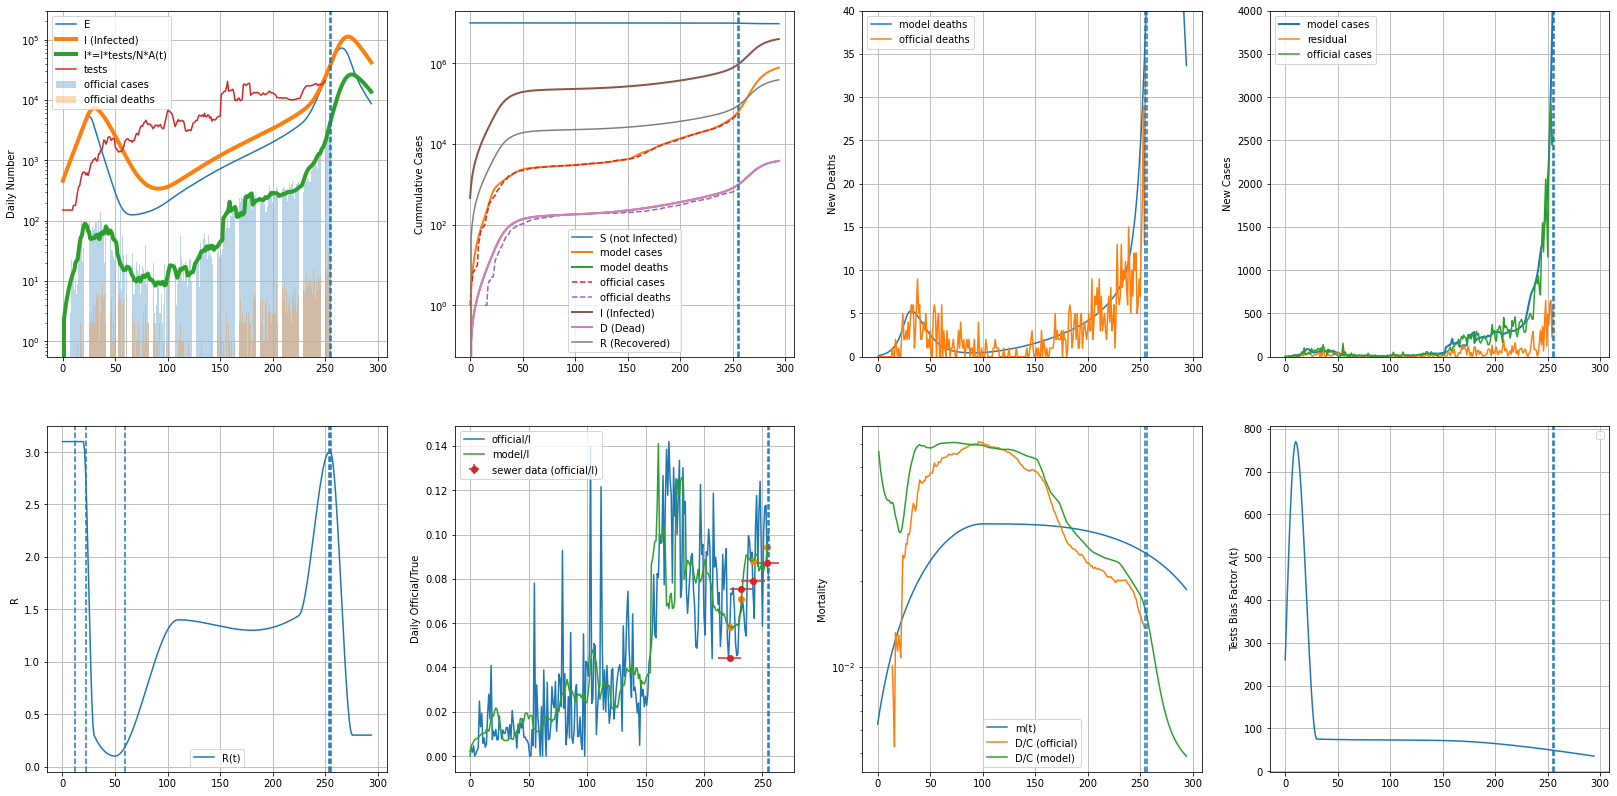

In [115]:
post=posterior(sol.x,bounds,p0,dp,parameters,usefit=False,maxt=256,plot={'cummulative_log':{'ylim':[0,2e7]}})

In [660]:

def mcmc_fit(posterior,walkers,nsteps,cores,bounds,p0,dp,args=None):
    ndim = bounds.shape[0] # How many parameters to fit
    nwalkers = ndim*walkers#60#16#4 # Minimum of 2 walkers per free parameter
    print(ndim,nwalkers/cores)
    pos = [np.random.uniform(bounds[:,0],bounds[:,1]) for i in range(nwalkers)]
    kwargs={'bounds':bounds,'p0':p0,'dp':dp}
    if args is not None: kwargs.update(args)
    #print(kwargs)
    if cores>1:
        with Pool(cores) as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior,pool=pool,kwargs=kwargs)# Setup the sampler
            result=sampler.run_mcmc(pos, nsteps,progress=True)
    else:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior,kwargs=kwargs)# Setup the sampler
        result=sampler.run_mcmc(pos, nsteps,progress=True)
    samples = sampler.chain[:, 0:, :].reshape((-1, ndim))
    return samples
def corner_res(sample,ranges=None,truths=None,fpars=None,sigmas=[1,2,3],smooth=1,savefig=None):
    med = np.quantile(samples,q=[0.25,0.5,0.75],axis=0)[1]    
    truths = med if truths is None else truths
    levels=[1-np.exp(-s**2/2) for s in sigmas]#(1-np.exp(-0.5**2/2),1-np.exp(-1**2/2),1-np.exp(-2**2/2),1-np.exp(-3**2/2))
    fpars = ['p{}'.format(i) for i in range(samples.shape[1])] if fpars is None else fpars
    Q=np.quantile(samples,q=[0.16,0.5,0.84],axis=0)
    if ranges is None:
        Q10=np.quantile(samples,q=[0.03,0.97],axis=0)
        ranges=Q10.T
    for fpar,q in zip(fpars,Q.T):
        print(f"Parameter {fpar} quantiles  ({q[0]:.2f} - {q[1]:.2f} - {q[2]:.2f})")
    fig = corner.corner(samples, labels=fpars,range=ranges,show_titles=True,truths=truths,quantiles=[0.16,0.5,0.84],levels=levels,smooth=smooth)#,truths=list(fit.best_values.values())
    return med
            